In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# Uncomment the next line for use in a Jupyter notebook
%matplotlib inline

In [72]:
# Read in the image
# There are six more images available for reading
# called sample1-6.jpg, feel free to experiment with the others!
image_name = 'f-tharangini_2017_07_14_02_DJI_0003.MP4-076.jpg'
#image_name = '/media/abhishek/6A140D7E140D4F0F/linux-data/test-datasets/sowparnika_thecolumn_2017_08_11/Images/thecolumn_2017-08-11_01_DJI_0121.JPG'
#image_name = '/media/abhishek/6A140D7E140D4F0F/linux-data/test-datasets/2017_09_04/Images/DJI_0433.JPG'
image = mpimg.imread(image_name)

In [73]:
# Define a function to perform a color threshold
def color_thresh(img, rgb_thresh=(0, 0, 0)):
    ###### TODO:
    # Create an empty array the same size in x and y as the image 
    # but just a single channel
    color_select = np.zeros_like(img[:,:,0])
    # Apply the thresholds for RGB and assign 1's 
    # where threshold was exceeded
    # Return the single-channel binary image
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            above_threshold = False
            for c in range(image.shape[2]):
                val = img[x, y, c]
                if val > rgb_thresh[c]:
                    above_threshold = True
            
            if above_threshold:
                #print(x, y, above_threshold)
                color_select[x, y] = 1
            else:
                color_select[x, y] = 0
    return color_select


In [74]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    #obstacle_select = np.zeros_like(img[:,:,0])
    #gold_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    
    bgr_img = img[...,::-1]
    # Convert BGR to HSV
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    
    # define range of gold color in HSV
    lower_gold = np.array([10,100,100])
    upper_gold = np.array([30,255,255])

    # Threshold the HSV image to get only gold colors
    mask = cv2.inRange(hsv, lower_gold, upper_gold)
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img, img, mask= mask)
    gold_thresh = (res[:,:,0] > 0) \
                & (res[:,:,1] > 0) 
            
    # Index the array of zeros with the boolean array and set to 1
    color_select[:] = 0
    color_select[above_thresh] = 1
    color_select[gold_thresh] = 0
    
    # Return the binary image
    return color_select
    #return (color_select, obstacle_select, gold_select)


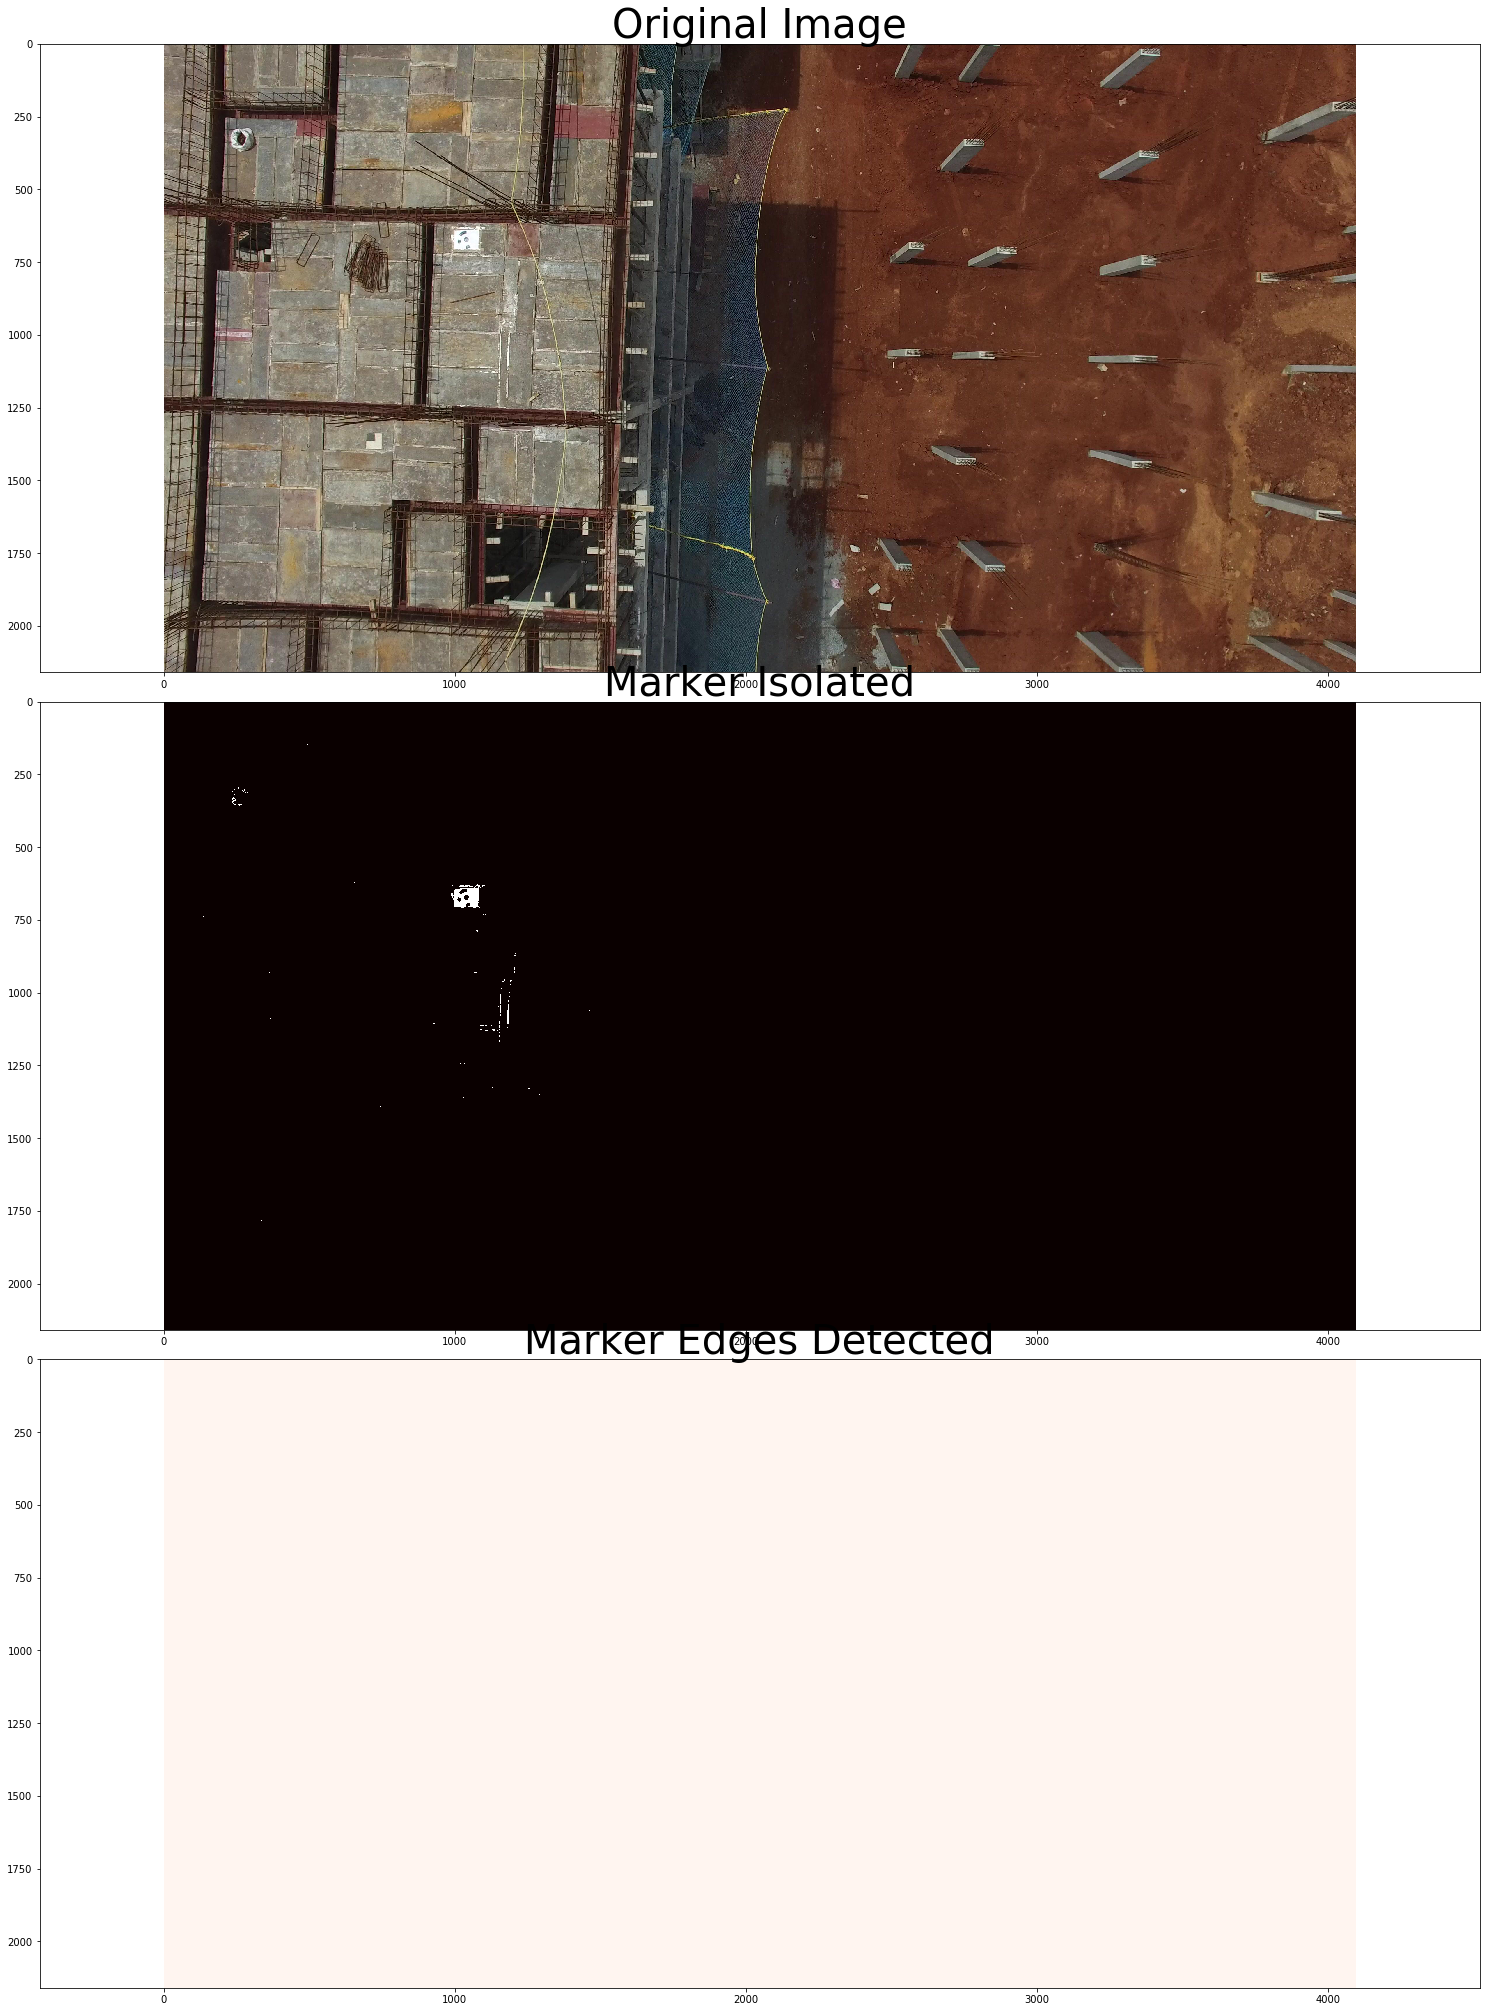

In [75]:
# Define color selection criteria
###### TODO: MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 225
green_threshold = 225
blue_threshold = 225
######
rgb_threshold = (red_threshold, green_threshold, blue_threshold)

# pixels below the thresholds
colorsel = color_thresh(image, rgb_thresh=rgb_threshold)

fwblur = cv2.blur(colorsel, (7,7))
fw_canny_edge = cv2.Canny(fwblur, 100, 120)

# Display the original image and binary               
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 30), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(colorsel, cmap='hot')
ax2.set_title('Marker Isolated', fontsize=40)

ax3.imshow(fw_canny_edge, cmap='Reds')
ax3.set_title('Marker Edges Detected', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


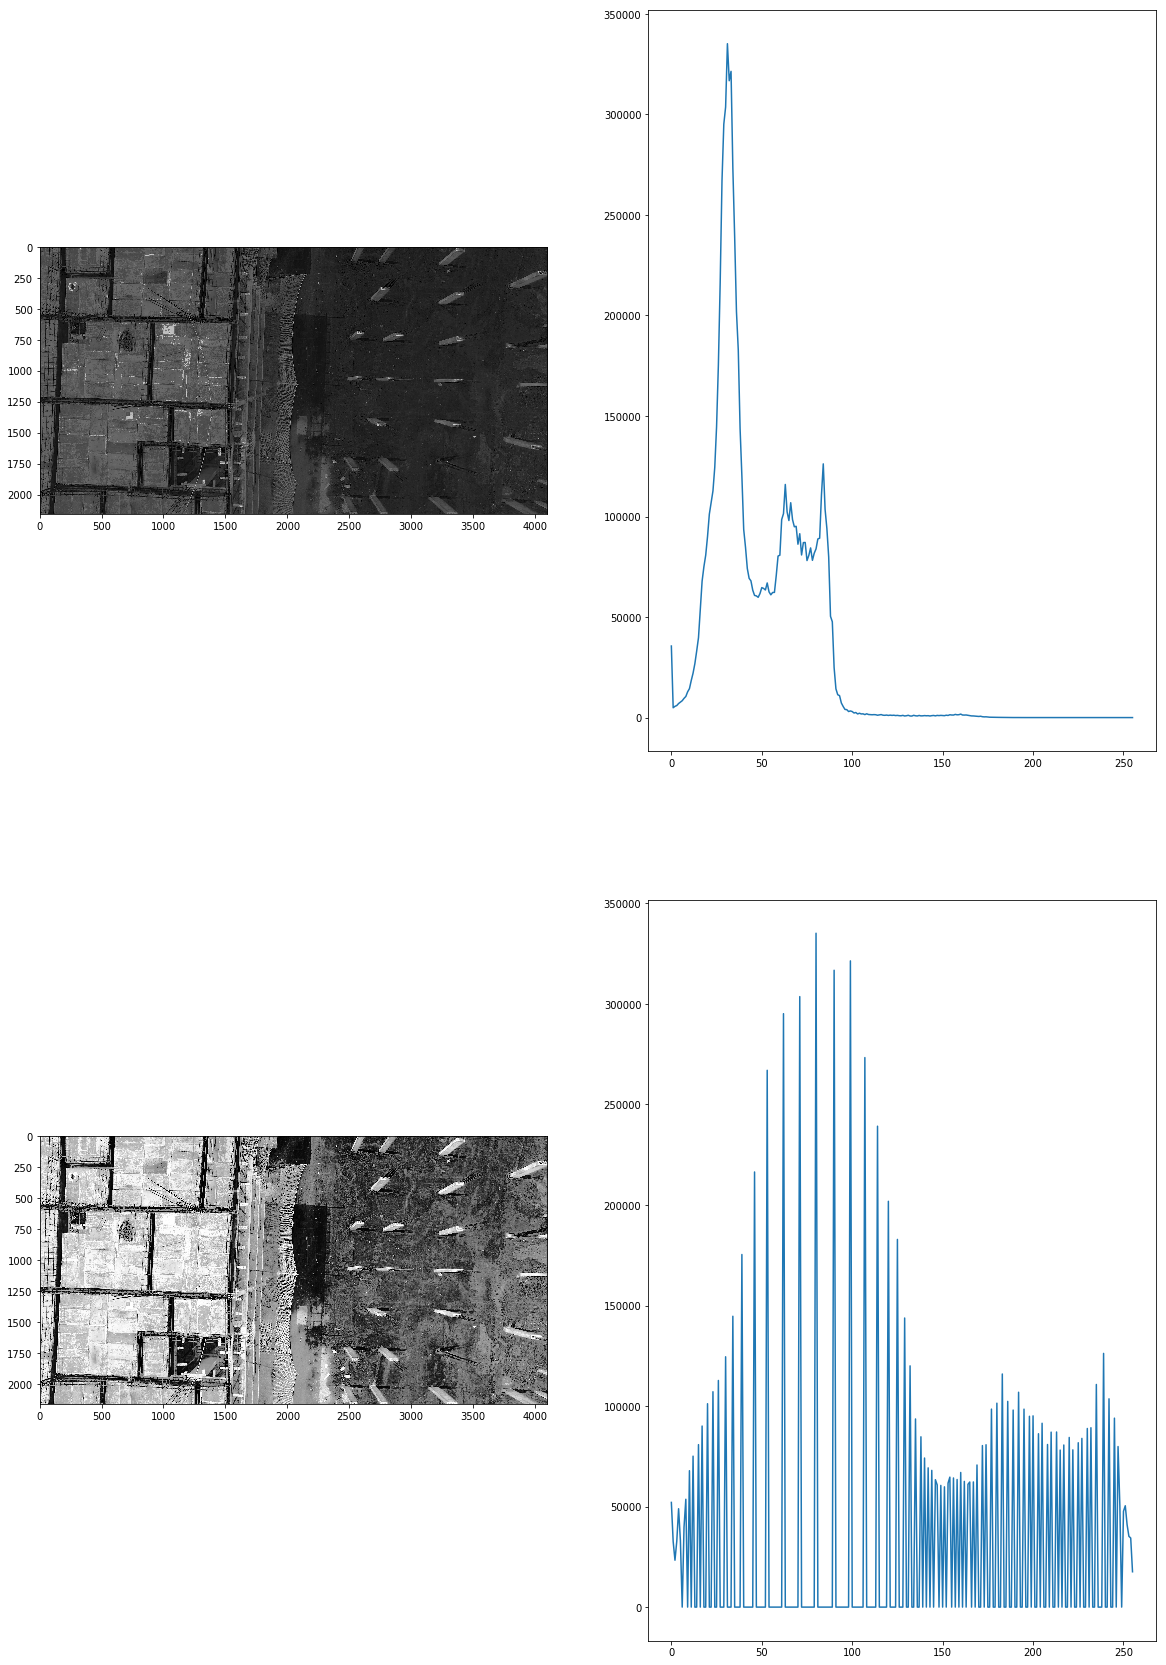

In [76]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hsv_image[:,:,2] -= 10

bgr_image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 30))
ax1.imshow(gray_image, 'gray')
hist_full = cv2.calcHist([gray_image],[0],None,[256],[0,256])
ax2.plot(hist_full)
gray_image2 = cv2.equalizeHist(gray_image)

ax3.imshow(gray_image2, 'gray')
hist_full2 = cv2.calcHist([gray_image2],[0],None,[256],[0,256])
ax4.plot(hist_full2)

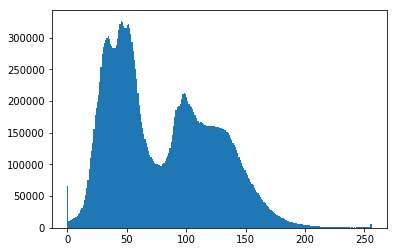

In [77]:
plt.hist(image.ravel(),256,[0,256]); plt.show()


True

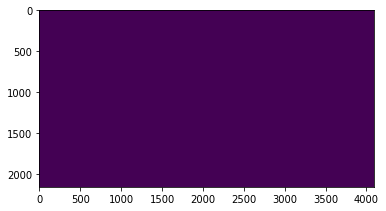

In [78]:
fwblur = cv2.blur(colorsel, (7,7))
fw_canny_edge = cv2.Canny(fwblur, 50, 150)
plt.imshow(fw_canny_edge)
cv2.imwrite('marker-edges.png',fw_canny_edge)

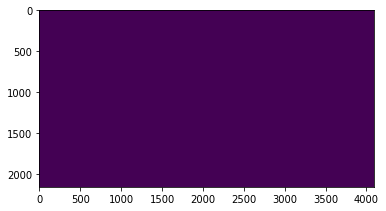

In [79]:
Z = colorsel.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((colorsel.shape))

plt.imshow(res2)



203 [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


array([  1,   2,   3, ..., 201, 202, 202], dtype=int32)

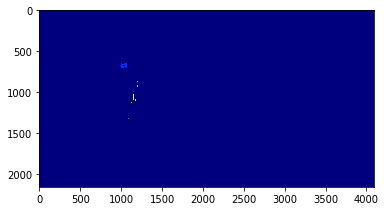

In [80]:
ret, markers = cv2.connectedComponents(colorsel)

print(ret, markers)

plt.imshow(markers, cmap='jet')

markers[markers != 0]

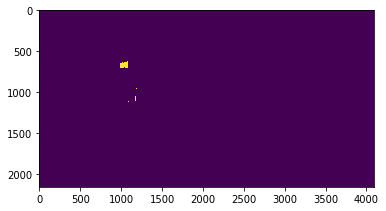

In [81]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(colorsel, cv2.MORPH_OPEN, kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
 
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

plt.imshow(sure_bg)

5 [[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


8847360

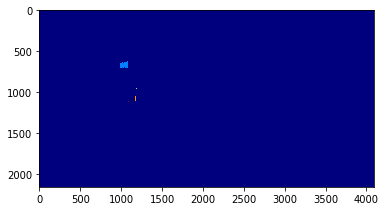

In [82]:
ret, markers = cv2.connectedComponents(sure_bg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
print(ret, markers)

plt.imshow(markers, cmap='jet')

len(markers[markers != 0])

In [83]:
markers = cv2.watershed(image,markers)
b_channel, g_channel, r_channel = cv2.split(image)
alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 50

#image[markers == 1] = [0,255,0]
for mx in range(2, ret+1):
    locs = np.where(markers == mx)
    print('number of pixels in connected component is ', len(locs[0]))
    if len(locs[0]) > 500:
        print((min(locs[0]), min(locs[1])), (max(locs[0]), max(locs[1])))

        if abs(min(locs[0]) - max(locs[0])) < 25 or abs(min(locs[1]) - max(locs[1])) < 25:
            print('Marker dimension discovered is too small, most probably a false positive')
        else:
            alpha_channel[markers==1]=150
            #alpha_channel[markers==2]=255
            img_BGRA = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
            margin = 50
            img_BGRA = cv2.rectangle(img_BGRA, (min(locs[1])-margin, min(locs[0])-margin), (max(locs[1])+margin, max(locs[0])+margin), (255, 0, 0, 255), 5)
            img_BGRA[min(locs[0])-margin: max(locs[0])+margin, min(locs[1])-margin:max(locs[1])+margin, 3] = 255

#             plt.imshow(img_BGRA)
#             plt.imshow(img_BGRA, cmap='jet')

            cv2.imwrite('detected_marker-' + str(mx) + '.png',img_BGRA)

number of pixels in connected component is  6441
(628, 985) (710, 1088)
number of pixels in connected component is  121
number of pixels in connected component is  782
(1044, 1175) (1110, 1189)
Marker dimension discovered is too small, most probably a false positive
number of pixels in connected component is  165


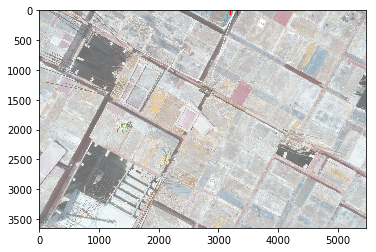

In [46]:
plt.imshow(img_BGRA)


In [6]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
              [4, 2], [4, 4], [4, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

kmeans.predict([[0, 0], [4, 4]])

kmeans.cluster_centers_


array([[ 1.,  2.],
       [ 4.,  2.]])

In [7]:
from sklearn import datasets


In [8]:
iris = datasets.load_iris()


In [9]:
colorsel

array([[100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       ..., 
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100],
       [100, 100, 100, ..., 100, 100, 100]], dtype=uint8)

In [94]:
def get_edges(image):
    img = cv2.blur(image, (7,7))

    for i in range(100, 200, 20):
        canny_edge = cv2.Canny(img, i, i+30)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 7), sharey=True)
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=40)

        ax2.imshow(canny_edge, cmap='hot')
        ax2.set_title('Edges ' + str([i, i+30]), fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# get_edges(image)

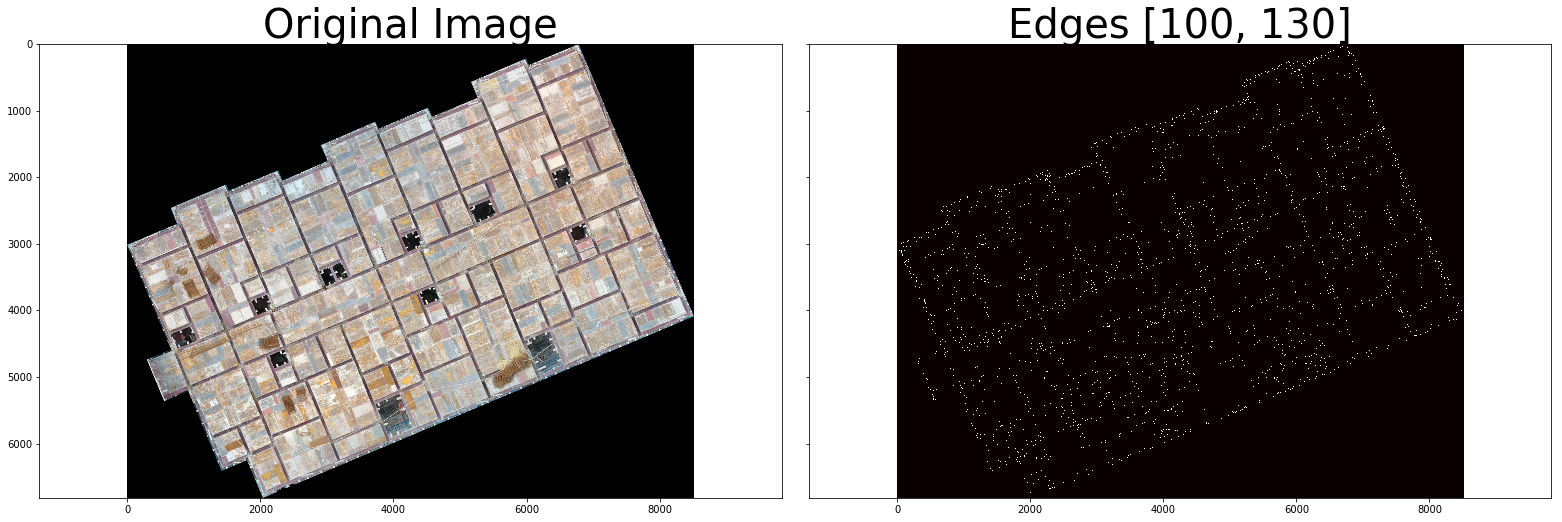

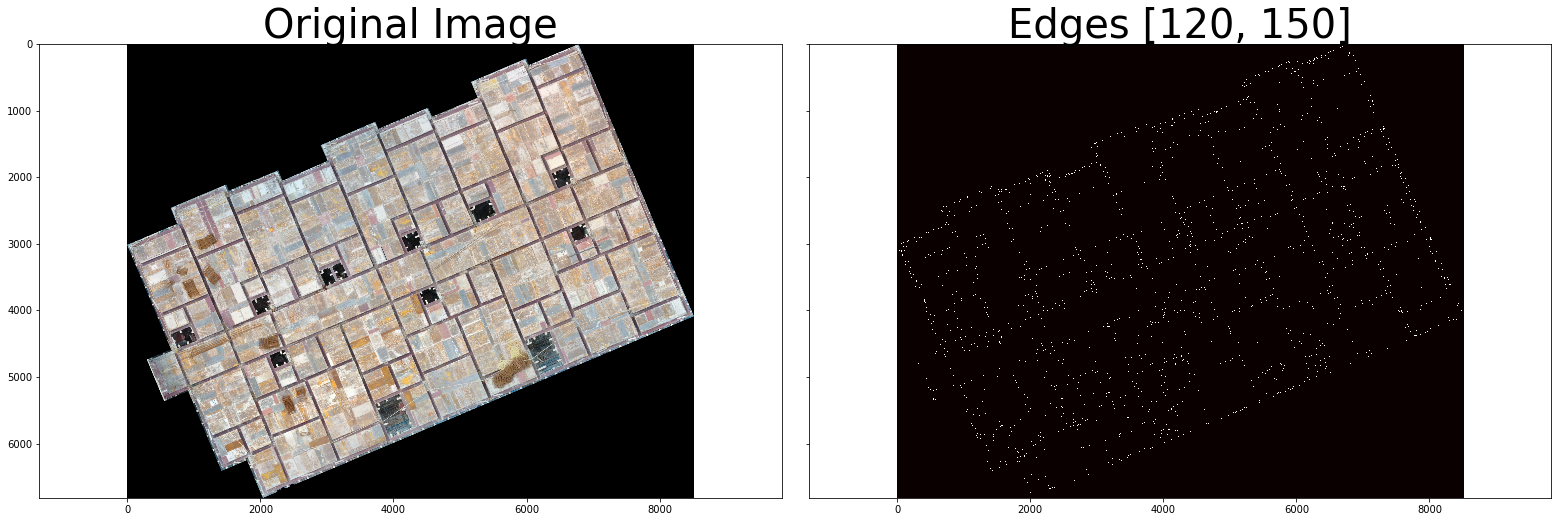

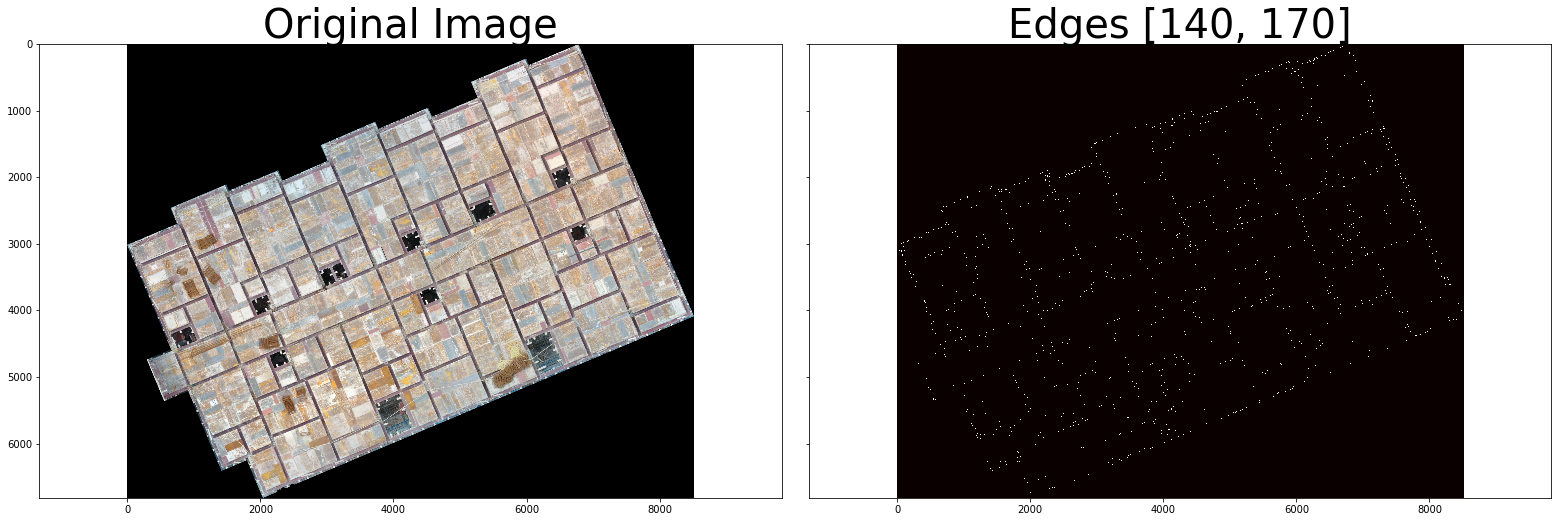

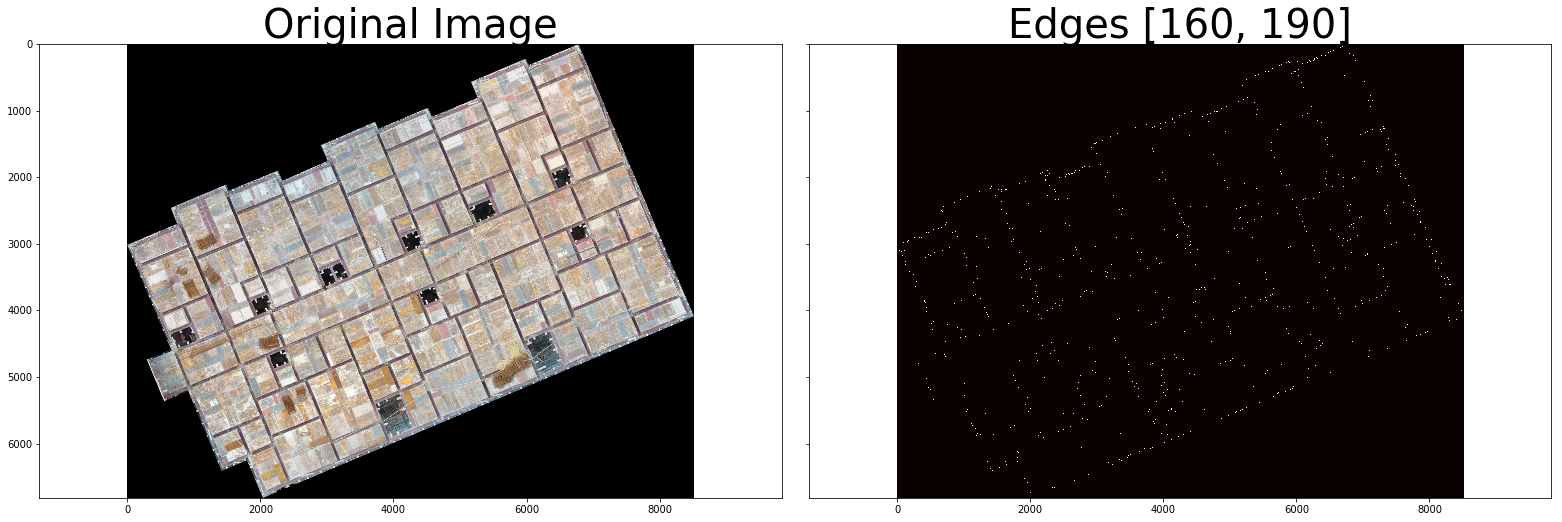

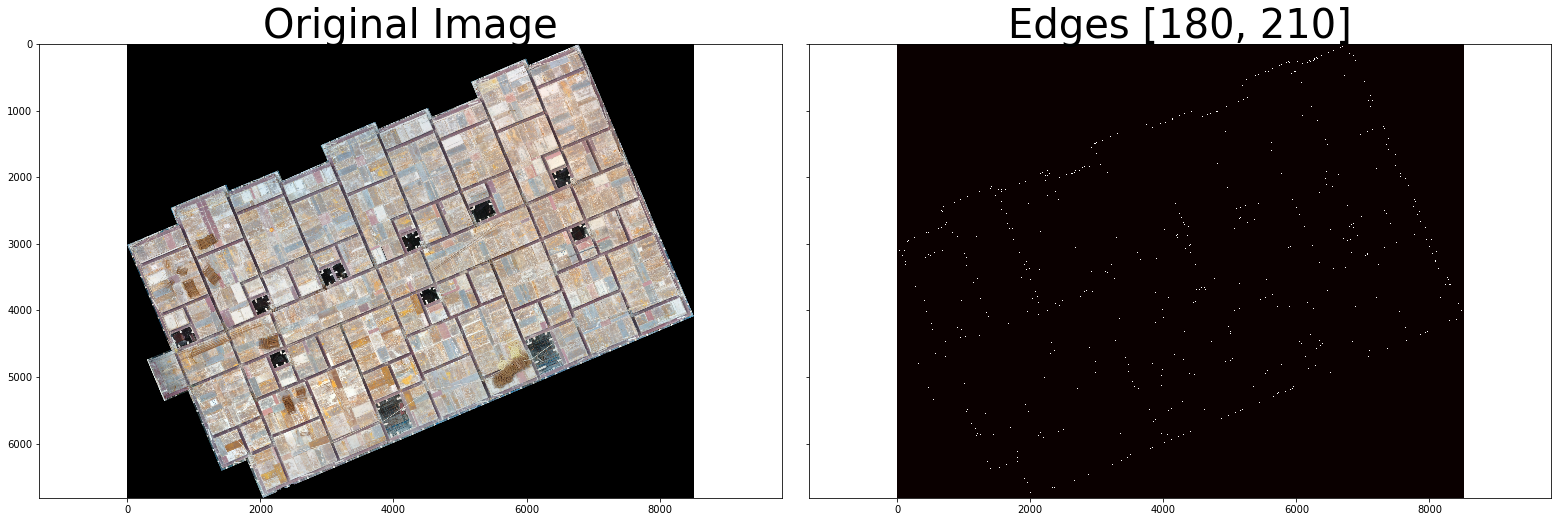

In [95]:
fw_name = 'input-fw2.jpeg'
fwimage = mpimg.imread(fw_name)

get_edges(fwimage)

True

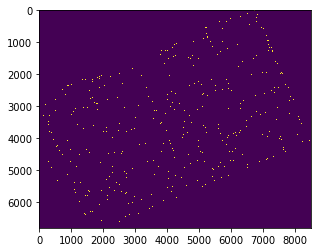

In [97]:
fwblur = cv2.blur(fwimage, (7,7))
fw_canny_edge = cv2.Canny(fwblur, 120, 150)
plt.imshow(fw_canny_edge)
cv2.imwrite('formwork-edges.png',fw_canny_edge)


In [72]:
fw_canny_edge = np.array(fw_canny_edge)


In [91]:
fw_canny_edge[fw_canny_edge>0] = 1

In [92]:
fw_canny_edge[fw_canny_edge==0] = 255

In [93]:
cv2.imwrite('formwork-edges.png',fw_canny_edge)

True